In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_BookCrossing'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/bookcrossing'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle
from sklearn import metrics

In [3]:
[df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat]=\
    pickle.load(open(f'{DATAPATH}/df_side_cold_runother_cf.pkl','rb'))

In [4]:
dftrain.columns

Index(['level_0', 'index', 'userId', 'itemId', 'rating',
       'num_ratings_per_user_gt_20', 'num_ratings_per_item_gt_200',
       'flag_clean_considered', 'Location', 'Age', 'Book-Title', 'Book-Author',
       'Year-Of-Publication', 'Publisher', 'random_dstype', 'user_idx',
       'item_idx', 'flag_train'],
      dtype='object')

In [5]:
dftrain.head().T

,0,1,2,3,4
level_0,0,1,2,3,4
index,275615,170503,70704,647,413358
userId,170762,100906,38281,277371,262541
itemId,0425175405,0151112495,8484504859,0007137699,0312963920
rating,9,9,5,6,7
num_ratings_per_user_gt_20,True,True,True,False,True
num_ratings_per_item_gt_200,True,False,False,False,False
flag_clean_considered,True,False,False,False,False
Location,"lansing, michigan, usa","seattle, washington, usa","barcelona, catalunya, spain","sydney, new south wales, australia","pierrefonds, quebec, canada"
Age,60,34,33,57,NaN


In [6]:
dftrain.columns

Index(['level_0', 'index', 'userId', 'itemId', 'rating',
       'num_ratings_per_user_gt_20', 'num_ratings_per_item_gt_200',
       'flag_clean_considered', 'Location', 'Age', 'Book-Title', 'Book-Author',
       'Year-Of-Publication', 'Publisher', 'random_dstype', 'user_idx',
       'item_idx', 'flag_train'],
      dtype='object')

In [7]:
dftrain.rename({'Book-Title':'BookTitle','Book-Author':'BookAuthor','Year-Of-Publication':'YearOfPublication'},axis=1,inplace=True)

In [8]:
dfvalid.rename({'Book-Title':'BookTitle','Book-Author':'BookAuthor','Year-Of-Publication':'YearOfPublication'},axis=1,inplace=True)

In [9]:
dftrain.isnull().sum()

level_0                             0
index                               0
userId                              0
itemId                              0
rating                              0
num_ratings_per_user_gt_20          0
num_ratings_per_item_gt_200         0
flag_clean_considered               0
Location                            0
Age                            115646
BookTitle                       44936
BookAuthor                      44937
YearOfPublication               44936
Publisher                       44938
random_dstype                       0
user_idx                            0
item_idx                            0
flag_train                          0
dtype: int64

In [10]:
for myNm in ['Age','BookTitle','BookAuthor','YearOfPublication','Publisher']:
    dftrain[myNm+'_NA']=dftrain[myNm].isnull().astype(int)
    dfvalid[myNm+'_NA']=dfvalid[myNm].isnull().astype(int)

In [11]:
for myNm in ['BookTitle','BookAuthor','YearOfPublication','Publisher']:
    dftrain[myNm].fillna('-1',inplace=True)
    dfvalid[myNm].fillna('-1',inplace=True)

In [12]:
for myNm in ['Age']:
    dftrain[myNm].fillna(-1,inplace=True)
    dfvalid[myNm].fillna(-1,inplace=True)

In [13]:
#Age, Location,  Book-Author, Year-Of-Publication, Publisher

In [14]:
df=pd.concat([dftrain,dfvalid],axis=0)

/home/kirana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [15]:
df.shape,df.head()

((433671, 35),     Age  Age_NA                 BookAuthor  BookAuthor_NA  \
 0  60.0       0  Patricia Daniels Cornwell              0   
 1  34.0       0              James Thurber              0   
 2  33.0       0         Mary Higgins Clark              0   
 3  57.0       0                         -1              1   
 4  -1.0       1                Dan Mahoney              0   
 
                                            BookTitle  BookTitle_NA  \
 0                                       Black Notice             0   
 1  The beast in me and other animals;: A collecti...             0   
 2                                  Un Extrano Acecha             0   
 3                                                 -1             1   
 4                                               Hyde             0   
 
                              Location                  Publisher  \
 0              lansing, michigan, usa   Berkley Publishing Group   
 1            seattle, washington, usa  Harcou

In [16]:
Publisher_to_idx={j:i+1 for i,j in enumerate(df['Publisher'].unique())}
idx_to_Publisher={i+1:j for i,j in enumerate(df['Publisher'].unique())}
YearOfPublication_to_idx={j:i+1 for i,j in enumerate(df['YearOfPublication'].unique())}
idx_to_YearOfPublication={i+1:j for i,j in enumerate(df['YearOfPublication'].unique())}
BookAuthor_to_idx={j:i+1 for i,j in enumerate(df['BookAuthor'].unique())}
idx_to_BookAuthor={i+1:j for i,j in enumerate(df['BookAuthor'].unique())}
Location_to_idx={j:i+1 for i,j in enumerate(df['Location'].unique())}
idx_to_Location={i+1:j for i,j in enumerate(df['Location'].unique())}
if 1==0:
    Age_to_idx={j:i+1 for i,j in enumerate(df['Age'].unique())}
    idx_to_Age={i+1:j for i,j in enumerate(df['Age'].unique())}

In [17]:
dftrain['Publisher_idx']=[Publisher_to_idx.get(i) for i in dftrain['Publisher']]
dfvalid['Publisher_idx']=[Publisher_to_idx.get(i) for i in dfvalid['Publisher']]
dftrain['YearOfPublication_idx']=[YearOfPublication_to_idx.get(i) for i in dftrain['YearOfPublication']]
dfvalid['YearOfPublication_idx']=[YearOfPublication_to_idx.get(i) for i in dfvalid['YearOfPublication']]

In [18]:

dftrain['BookAuthor_idx']=[BookAuthor_to_idx.get(i) for i in dftrain['BookAuthor']]
dfvalid['BookAuthor_idx']=[BookAuthor_to_idx.get(i) for i in dfvalid['BookAuthor']]

In [19]:

dftrain['Location_idx']=[Location_to_idx.get(i) for i in dftrain['Location']]
dfvalid['Location_idx']=[Location_to_idx.get(i) for i in dfvalid['Location']]

In [20]:
if 1==0:
    dftrain['Age_idx']=[Age_to_idx.get(i) for i in dftrain['Age']]
    dfvalid['Age_idx']=[Age_to_idx.get(i) for i in dfvalid['Age']]

In [21]:
catCols=['Publisher_idx','YearOfPublication_idx','BookAuthor_idx','Location_idx']

In [27]:
if 1==1:
    catCols=catCols+[x[:-4]+'_NA' for x in catCols]

In [23]:
denseCols=['Age','Age_NA']

In [24]:
catCols

['Publisher_idx', 'YearOfPublication_idx', 'BookAuthor_idx', 'Location_idx']

In [28]:
catCols

['Publisher_idx',
 'YearOfPublication_idx',
 'BookAuthor_idx',
 'Location_idx',
 'Publisher_NA',
 'YearOfPublication_NA',
 'BookAuthor_NA',
 'Location_NA']

In [31]:
catCols.remove('Location_NA')

In [32]:
dftrain.columns

Index(['level_0', 'index', 'userId', 'itemId', 'rating',
       'num_ratings_per_user_gt_20', 'num_ratings_per_item_gt_200',
       'flag_clean_considered', 'Location', 'Age', 'BookTitle', 'BookAuthor',
       'YearOfPublication', 'Publisher', 'random_dstype', 'user_idx',
       'item_idx', 'flag_train', 'Age_NA', 'BookTitle_NA', 'BookAuthor_NA',
       'YearOfPublication_NA', 'Publisher_NA', 'Publisher_idx',
       'YearOfPublication_idx', 'BookAuthor_idx', 'Location_idx'],
      dtype='object')

In [33]:
dftrain[catCols].head()

,Publisher_idx,YearOfPublication_idx,BookAuthor_idx,Location_idx,Publisher_NA,YearOfPublication_NA,BookAuthor_NA
0,1,1,1,1,0,0,0
1,2,2,2,2,0,0,0
2,3,3,3,3,0,0,0
3,4,4,4,4,1,1,1
4,5,5,5,5,0,0,0


In [34]:
dftrain[catCols].max()

Publisher_idx            11033
YearOfPublication_idx      180
BookAuthor_idx           58538
Location_idx             20401
Publisher_NA                 1
YearOfPublication_NA         1
BookAuthor_NA                1
dtype: int64

### Dataset and DataLoader

In [47]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY,denseCols,catCols):
        self.dfX,self.dfY=dfX,dfY
        self.denseCols=denseCols
        self.catCols=catCols
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [48]:
dstrain=cfdata(dftrain[['user_idx','item_idx']+catCols+denseCols],dftrain['rating'],denseCols,catCols)
dsvalid=cfdata(dfvalid[['user_idx','item_idx']+catCols+denseCols],dfvalid['rating'],denseCols,catCols)

In [49]:
dftrain.shape

(390999, 27)

In [50]:
bs=64

In [51]:
dltrain=DataLoader(dstrain,bs,False)

In [52]:
dlvalid=DataLoader(dsvalid,bs,False)

In [53]:
[(col, dftrain[col].nunique()) for col in catCols]

[('Publisher_idx', 11033),
 ('YearOfPublication_idx', 180),
 ('BookAuthor_idx', 58538),
 ('Location_idx', 20401),
 ('Publisher_NA', 2),
 ('YearOfPublication_NA', 2),
 ('BookAuthor_NA', 2)]

In [54]:
{col: min(50,dftrain[col].nunique()//2) for col in catCols}

{'Publisher_idx': 50,
 'YearOfPublication_idx': 50,
 'BookAuthor_idx': 50,
 'Location_idx': 50,
 'Publisher_NA': 1,
 'YearOfPublication_NA': 1,
 'BookAuthor_NA': 1}

In [55]:
df=pd.concat([dftrain,dfvalid],axis=0)

/home/kirana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [56]:
emb_szs=[(df[col].nunique(),min(50,df[col].nunique()//2)) for col in catCols]

In [57]:
emb_szs

[(11576, 50), (182, 50), (62114, 50), (21335, 50), (2, 1), (2, 1), (2, 1)]

In [58]:
dftrain[catCols].head()

,Publisher_idx,YearOfPublication_idx,BookAuthor_idx,Location_idx,Publisher_NA,YearOfPublication_NA,BookAuthor_NA
0,1,1,1,1,0,0,0
1,2,2,2,2,0,0,0
2,3,3,3,3,0,0,0
3,4,4,4,4,1,1,1
4,5,5,5,5,0,0,0


## Model Architecture

In [102]:
n_users=len(user_to_idx)
n_items=len(item_to_idx)
n_emb_user=25
n_emb_item=25
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.1
    # emb, bias, cat, dense,hidden1,hidden2
hidden=[20,1,10,1,15,5,1]
    # emb,bias,cat,dense,hidden1,hidden2
dropouts=[0.2,0.2,0.2,0.2,0.2,0.1,0]

In [103]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [104]:
#[mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb]=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))
pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))


In [108]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,autoenc_cols,pretrain_wts,\
                 catCols,  emb_szs,dropout_e=0.01,hidden=[15,5],dropouts=[0.2,0.2],error_type="mse",\
                lambda_l2=0.1,lambda_l1=0.1,use_l1=False,use_l2=False):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e,self.hidden,self.dropouts=dropout_e,hidden,dropouts
        self.autoenc_cols,self.len_dense_cols=autoenc_cols,len(autoenc_cols)
        self.catCols,self.emb_szs=catCols,emb_szs
        self.lambda_l2,self.lambda_l1=lambda_l2,lambda_l1
        self.use_l1,self.use_l2=use_l1,use_l2
        self.len_cat_cols=len(self.catCols)
        self.n_cat_emb=sum([x[1] for x in emb_szs])
        self.n_dense=len(self.autoenc_cols)
        self.l1_crit=nn.L1Loss()
        self.l2_crit=nn.MSELoss()
        
        self.create_architecture()
        #self.init_parameters()
        
        if pretrain_wts is not None:
            self.emb_user.weight.data=torch.FloatTensor(pretrain_wts[0])
            self.emb_item.weight.data=torch.FloatTensor(pretrain_wts[1])
            self.ub.weight.data=torch.FloatTensor(pretrain_wts[2])
            self.ib.weight.data=torch.FloatTensor(pretrain_wts[3])

        if error_type!="mse":
            self.criterion=nn.L1Loss()
        else:
            self.criterion=nn.MSELoss()
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)
        self.embs_cat=nn.ModuleList([nn.Embedding(x+1,y) for x,y in self.emb_szs])
        
        self.emb_dropout=nn.Dropout(self.dropout_e)

        
        self.lin_emb= nn.Sequential(nn.Linear(self.n_emb_user+self.n_emb_item,self.hidden[0]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[0]) ,
                    nn.BatchNorm1d(self.hidden[0]))
        self.lin_bias=nn.Sequential(nn.Linear(2,self.hidden[1]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[1]) ,
                    nn.BatchNorm1d(self.hidden[1]))
        self.lin_cat= nn.Sequential (nn.Linear(self.n_cat_emb,self.hidden[2]),
                                nn.ReLU(),
                                nn.Dropout(p=dropouts[2]),
                            nn.BatchNorm1d(self.hidden[2]))
        self.lin_dense= nn.Sequential (nn.Linear(self.n_dense,self.hidden[3]),
                                nn.ReLU(),
                                nn.Dropout(p=dropouts[3]),
                            nn.BatchNorm1d(self.hidden[3]))        
        
        self.lin3= nn.Sequential (nn.Linear(self.hidden[0]+self.hidden[1]+self.hidden[2]+self.hidden[3],\
                                            self.hidden[4]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[4]),
                    nn.BatchNorm1d(self.hidden[4]))
        self.lin4=nn.Sequential (nn.Linear(self.hidden[4],\
                                            self.hidden[5]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[5]),
                    nn.BatchNorm1d(self.hidden[5]))
        self.lin5=nn.Linear(self.hidden[5],self.hidden[6])
        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.zeros_(self.ub.weight.data)
        nn.init.zeros_(self.ib.weight.data)
        nn.init.kaiming_normal_(self.lin1[0].weight.data)

        nn.init.kaiming_normal_(self.lin3[0].weight.data)
        #nn.init.kaiming_normal_(lin)
        
        
    def add_l2_reg (self,lin_parameters):
        lin = torch.cat([x.view(-1) for x in lin_parameters])
        l2=self.lambda_l2 * torch.norm(lin,2)
        return l2
        
    def add_l1_reg (self,lin_parameters):
        lin = torch.cat([x.view(-1) for x in lin_parameters])
        l1=self.lambda_l1 * torch.norm(lin,1)
        return l1    
       
    def forward (self,Xb,Yb):
        
        # EMBEDDINGS - USER AND ITEM
        users=Xb[:,0].long()
        items=Xb[:,1].long()
        users=self.emb_dropout(self.emb_user(users))
        items=self.emb_dropout(self.emb_item(items))
        users_bias=self.emb_dropout(self.ub(Xb[:,0].long()))
        items_bias=self.emb_dropout(self.ib(Xb[:,1].long()))
        embed=torch.cat([users,items],1)
        out_embs=self.lin_emb(embed)
        bias=torch.cat([users_bias,items_bias],1)
        biased=self.lin_bias(bias)
           
        # CATEGORICAL FEATURES
        cats=Xb[:,2:(2+self.len_cat_cols)].long()
        embed_cat=[self.emb_dropout(self.embs_cat[i](cats[:,i]) ) for i in range(len(self.emb_szs))]
        embedded_cat = torch.cat([x for x in embed_cat],1)
        out_cat=self.lin_cat(embedded_cat)
        
        # DENSE FEATURES
        denses=Xb[:,(2+self.len_cat_cols):]
        out_dense=self.lin_dense(denses)
        
        
        out3=torch.cat([out_embs,biased,out_cat,out_dense],1)
        
        out4=self.lin3(out3)
        
        out5=self.lin4(out4)
        
        out6=self.lin5(out5)
        
        out=self.sigmoid(out6)
        
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        #preds=preds.view(-1)
        loss=self.criterion(preds,Yb)
        if self.use_l2:
            loss = loss +  self.add_l2_reg(self.lin_emb.parameters()) + \
                    self.add_l2_reg(self.lin_bias.parameters()) + \
                    self.add_l2_reg(self.lin_cat.parameters()) + \
                    self.add_l2_reg(self.lin_dense.parameters()) + \
                    self.add_l2_reg (self.lin3.parameters()) + \
                    self.add_l2_reg (self.lin4.parameters())+ self.add_l2_reg (self.lin5.parameters())
        
        
        
        
        return preds,loss

In [109]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,catCols,emb_szs,dropout_e,hidden,dropouts,error_type="mse",lambda_l2=1e-4)

In [110]:
cfobj

cf(
  (l1_crit): L1Loss()
  (l2_crit): MSELoss()
  (emb_user): Embedding(77806, 25)
  (emb_item): Embedding(185974, 25)
  (ub): Embedding(77806, 1)
  (ib): Embedding(185974, 1)
  (embs_cat): ModuleList(
    (0): Embedding(11577, 50)
    (1): Embedding(183, 50)
    (2): Embedding(62115, 50)
    (3): Embedding(21336, 50)
    (4): Embedding(3, 1)
    (5): Embedding(3, 1)
    (6): Embedding(3, 1)
  )
  (emb_dropout): Dropout(p=0.1, inplace=False)
  (lin_emb): Sequential(
    (0): Linear(in_features=50, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin_bias): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin_cat): Sequential(
    (0): Linear(in_features=203, out_features=10, bias=True)
   

In [111]:
for Xb, Yb in dltrain:
    break

In [112]:
Xb.shape, Yb.shape

(torch.Size([64, 11]), torch.Size([64, 1]))

In [113]:
cfobj.forward(Xb,Yb)

(tensor([[4.1903],
         [5.2904],
         [2.1759],
         [4.9955],
         [7.3840],
         [1.8760],
         [4.4024],
         [5.7227],
         [4.5874],
         [2.6452],
         [1.7859],
         [5.7227],
         [4.8771],
         [5.7841],
         [4.1507],
         [4.7839],
         [5.9891],
         [2.8845],
         [3.6672],
         [5.5754],
         [4.6934],
         [6.8073],
         [4.4079],
         [4.2294],
         [5.7227],
         [4.3661],
         [4.0477],
         [5.4403],
         [4.3024],
         [4.8339],
         [1.2267],
         [4.6314],
         [3.6362],
         [5.2395],
         [4.8758],
         [6.4848],
         [7.5013],
         [5.0281],
         [4.3460],
         [5.7017],
         [5.0623],
         [4.9957],
         [5.4444],
         [2.1115],
         [4.3184],
         [4.8423],
         [4.9965],
         [4.3814],
         [4.7242],
         [4.1799],
         [4.2603],
         [5.7227],
         [5.

## Learner

In [114]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=1.1,start_lr=2e-2, end_lr=5e-4,error_type="mse"):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        self.scores=[]
        self.generate_scores=False
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
        if mode_train==False:
            if self.generate_scores:
                self.scores.append(preds.detach().cpu().numpy().flatten())
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} Train MSE:{loss_mse} Valid MSE:{lossv_mse} \
                Train MAE:{loss_mae} Valid MAE:{lossv_mae}')

              
         
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                param_group['weight_decay']=self.wd
          
     

In [115]:
device='cuda:1'

In [116]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,\
         catCols,emb_szs,dropout_e,hidden,dropouts,error_type="mse",use_l1=0,use_l2=0)

In [117]:
cfobj=cfobj.to(device)

In [118]:
cfobj

cf(
  (l1_crit): L1Loss()
  (l2_crit): MSELoss()
  (emb_user): Embedding(77806, 25)
  (emb_item): Embedding(185974, 25)
  (ub): Embedding(77806, 1)
  (ib): Embedding(185974, 1)
  (embs_cat): ModuleList(
    (0): Embedding(11577, 50)
    (1): Embedding(183, 50)
    (2): Embedding(62115, 50)
    (3): Embedding(21336, 50)
    (4): Embedding(3, 1)
    (5): Embedding(3, 1)
    (6): Embedding(3, 1)
  )
  (emb_dropout): Dropout(p=0.1, inplace=False)
  (lin_emb): Sequential(
    (0): Linear(in_features=50, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin_bias): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin_cat): Sequential(
    (0): Linear(in_features=203, out_features=10, bias=True)
   

In [119]:
wd=5e-5
optimizer=torch.optim.SGD(cfobj.parameters(),lr=5e-3,momentum=0.9, weight_decay=wd,nesterov=True)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=0)

In [120]:
len(dltrain)

6110

In [121]:
learner.lr_find(5e-5,1e-2,dltrain,len(dltrain))

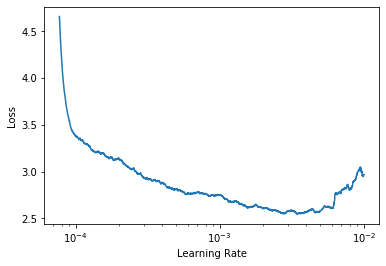

In [134]:
learner.plot_lrs(500)

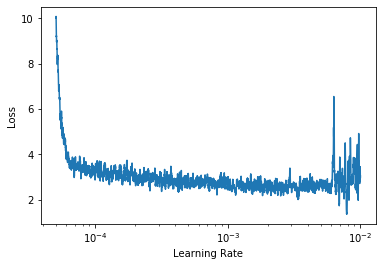

In [123]:
learner.plot_lrs(10)

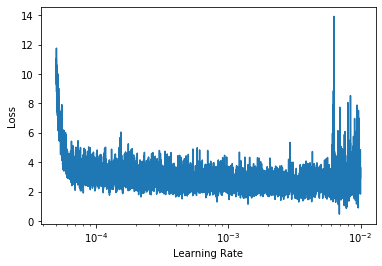

In [124]:
learner.plot_lrs(1)

In [125]:
cfobj.dropouts

[0.2, 0.2, 0.2, 0.2, 0.2, 0.1, 0]

In [126]:
del cfobj
torch.cuda.empty_cache()

In [128]:
pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))

In [129]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,catCols,\
             emb_szs,dropout_e,hidden, error_type="mse",lambda_l2=2e-1,lambda_l1=1e-3,use_l1=0,use_l2=0)
cfobj=cfobj.to(device)

In [130]:
cfobj

cf(
  (l1_crit): L1Loss()
  (l2_crit): MSELoss()
  (emb_user): Embedding(77806, 25)
  (emb_item): Embedding(185974, 25)
  (ub): Embedding(77806, 1)
  (ib): Embedding(185974, 1)
  (embs_cat): ModuleList(
    (0): Embedding(11577, 50)
    (1): Embedding(183, 50)
    (2): Embedding(62115, 50)
    (3): Embedding(21336, 50)
    (4): Embedding(3, 1)
    (5): Embedding(3, 1)
    (6): Embedding(3, 1)
  )
  (emb_dropout): Dropout(p=0.1, inplace=False)
  (lin_emb): Sequential(
    (0): Linear(in_features=50, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin_bias): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin_cat): Sequential(
    (0): Linear(in_features=203, out_features=10, bias=True)
   

In [131]:
if 1==0:
    cfobj.emb_user.weight.requires_grad=False
    cfobj.emb_item.weight.requires_grad=False
    cfobj.ib.weight.requires_grad=False
    cfobj.ub.weight.requires_grad=False

In [132]:
wd

5e-05

In [135]:
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd,amsgrad=True)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=5e-4,end_lr=5e-5,wd_mult=1.1)

In [136]:
learner.run_epochs(dltrain,dlvalid,3)

Epoch:0 Learning rate 0.005 Weight Decay 5e-05 Train Loss:3.01272746392826                 Valid Loss:2.963087219705825 Train RMSE:1.7219315154988066 Valid RMSE:1.7084893378752077 Train MSE:3.01272746392826 Valid MSE:2.963087219705825                 Train MAE:1.3694420001510708 Valid MAE:1.3102997474405897
Epoch:1 Learning rate 0.0005 Weight Decay 5.500000000000001e-05 Train Loss:2.3201038110275705                 Valid Loss:2.9020847051754886 Train RMSE:1.5084046266739732 Valid RMSE:1.6913854107390052 Train MSE:2.3201038110275705 Valid MSE:2.9020847051754886                 Train MAE:1.1750729335212864 Valid MAE:1.3090078487567816
Epoch:2 Learning rate 5e-05 Weight Decay 6.0500000000000014e-05 Train Loss:2.0966652299983215                 Valid Loss:3.0593102648519146 Train RMSE:1.431670175358891 Valid RMSE:1.7370875375569355 Train MSE:2.0966652299983215 Valid MSE:3.0593102648519146                 Train MAE:1.0997804347992723 Valid MAE:1.3498991536593687


In [137]:
learner.run_epochs(dltrain,dlvalid,4)

Epoch:0 Learning rate 0.005 Weight Decay 5e-05 Train Loss:2.293751268622918                 Valid Loss:3.151483245696621 Train RMSE:1.5027147886954457 Valid RMSE:1.7618719861088923 Train MSE:2.293751268622918 Valid MSE:3.151483245696621                 Train MAE:1.1708297058525334 Valid MAE:1.3483108386643108
Epoch:1 Learning rate 0.0015811388300841897 Weight Decay 5.500000000000001e-05 Train Loss:2.0615551735785123                 Valid Loss:3.0633865392905126 Train RMSE:1.4236081465976549 Valid RMSE:1.7369884925169705 Train MSE:2.0615551735785123 Valid MSE:3.0633865392905126                 Train MAE:1.108003150236392 Valid MAE:1.3247315031120266
Epoch:2 Learning rate 0.0005 Weight Decay 6.0500000000000014e-05 Train Loss:1.751839509162497                 Valid Loss:2.9846940823402006 Train RMSE:1.3099901261910785 Valid RMSE:1.7151167547226756 Train MSE:1.751839509162497 Valid MSE:2.9846940823402006                 Train MAE:1.0037780343803369 Valid MAE:1.3057609448011132
Epoch:3 Lear

In [148]:
learner.run_epochs(dltrain,dlvalid,8)

Epoch:0 Learning rate 5e-05 Weight Decay 7.320500000000003e-05 Train Loss:1.5707244460691991                 Valid Loss:3.0195314603588215 Train RMSE:1.2388100616464095 Valid RMSE:1.725602925699813 Train MSE:1.5707244460691991 Valid MSE:3.0195314603588215                 Train MAE:0.9365162101100197 Valid MAE:1.3204495498444186
Epoch:1 Learning rate 0.005 Weight Decay 5e-05 Train Loss:1.9032940014099333                 Valid Loss:3.242873936936237 Train RMSE:1.3673266892448928 Valid RMSE:1.7892072011326743 Train MSE:1.9032940014099333 Valid MSE:3.242873936936237                 Train MAE:1.053374315410511 Valid MAE:1.3652607582319622
Epoch:2 Learning rate 0.0028117066259517455 Weight Decay 5.500000000000001e-05 Train Loss:1.7597746155119567                 Valid Loss:3.0714872995059173 Train RMSE:1.3137229754915485 Valid RMSE:1.7392078097590518 Train MSE:1.7597746155119567 Valid MSE:3.0714872995059173                 Train MAE:1.0103682712817934 Valid MAE:1.325519945399872
Epoch:3 Lear

In [147]:
device

'cuda:1'

In [138]:
learner.generate_scores=True

In [139]:
learner.run_epoch(dlvalid,False)

(2.9369837866015343, 1.2991075127021126, 1.7014904349417916)

In [140]:
dfvalid['pred_dnnrec']=np.concatenate(learner.scores)

In [141]:
np.sqrt(metrics.mean_squared_error(dfvalid['rating'],dfvalid['pred_dnnrec']))

1.7133682147133726

In [142]:
def score_by_group (dfvalid,predVar,groupVar='cold_start_group',method='global_avg'):
    scores=[]
    mae_scores=[]
    rmse_scores=[]
    r2_scores=[]
    groups=dfvalid[groupVar].value_counts().index.tolist()
    for group in groups:
        df=dfvalid.loc[dfvalid[groupVar]==group]
        actual=df['rating']
        score=metrics.mean_squared_error(df['rating'],df[predVar])
        rmse_score=np.sqrt(metrics.mean_squared_error(df['rating'],df[predVar]))
        mae_score=metrics.mean_absolute_error(df['rating'],df[predVar])
        r2_score=metrics.r2_score(df['rating'],df[predVar])
        scores.append(score)
        mae_scores.append(mae_score)
        rmse_scores.append(rmse_score)
        r2_scores.append(r2_score)
    return pd.DataFrame({'method':method, 'mse':scores, 'rmse':rmse_scores, 'mae':mae_scores, 'r2_score':r2_scores, 'Cold Start Group':groups})

In [143]:
result_dnnrec=pd.concat([score_by_group(dfvalid,'pred_dnnrec','cold_start_group','dnnrec'),score_by_group(dfvalid,'pred_dnnrec','cold_start_bucket','dnnrec'),\
score_by_group(dfvalid,'pred_dnnrec','flag_train','dnnrec')],axis=0)
result_dnnrec

,method,mse,rmse,mae,r2_score,Cold Start Group
0,dnnrec,2.799009,1.673024,1.263449,0.156440,No-cold-start
1,dnnrec,2.737666,1.654590,1.226200,0.245879,Item-Cold_start
2,dnnrec,3.529919,1.878808,1.470685,-0.031895,User-Cold-Start
3,dnnrec,3.912971,1.978123,1.612154,0.003887,User-Item-cold-start
0,dnnrec,2.799009,1.673024,1.263449,0.156440,0
1,dnnrec,3.111505,1.763946,1.344347,0.137903,1
0,dnnrec,2.935631,1.713368,1.298817,0.150134,0


In [144]:
results_concat.shape

(56, 6)

In [145]:
results_concat=pd.concat([results_concat,result_dnnrec],axis=0)

In [146]:
pickle.dump([df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat],open(f'{DATAPATH}/df_side_cold_runother_dnnrec_new.pkl','wb'))